In [1]:
import pandas as pd
import pandasql as psq # conda install -c anaconda pandasql 
import duckdb # pip install duckdb
from pandas_profiling import ProfileReport # pip install -U pandas-profiling[notebook]==3.2.0 markupsafe==2.0.1
import numpy as np
from patsy import dmatrices
from sklearn import preprocessing

from statsmodels.compat import lzip
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rc("figure", figsize=(16, 8))
plt.rc("font", size=14)


In [2]:
df = pd.read_csv ('../data/cleaned_online_retail.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401564 entries, 0 to 401563
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   401564 non-null  int64  
 1   invoiceno    401564 non-null  object 
 2   stockcode    401564 non-null  object 
 3   description  401564 non-null  object 
 4   quantity     401564 non-null  int64  
 5   invoicedate  401564 non-null  object 
 6   unitprice    401564 non-null  float64
 7   customerid   401564 non-null  int64  
 8   country      401564 non-null  object 
 9   cancel       401564 non-null  bool   
 10  amount       401564 non-null  float64
dtypes: bool(1), float64(2), int64(3), object(5)
memory usage: 31.0+ MB


In [3]:
print(df.columns)

Index(['Unnamed: 0', 'invoiceno', 'stockcode', 'description', 'quantity',
       'invoicedate', 'unitprice', 'customerid', 'country', 'cancel',
       'amount'],
      dtype='object')


In [4]:
#Dropping unnecessary columns
if 'Unnamed: 0' in list(df.columns):
    df.drop(['Unnamed: 0'], axis=1, inplace=True)
#rename specific column names
df.rename(columns = {'description':'product'}, inplace = True)
# column type change
df['customerid'] = df['customerid'].astype(int).astype(str)
print(df.columns)

Index(['invoiceno', 'stockcode', 'product', 'quantity', 'invoicedate',
       'unitprice', 'customerid', 'country', 'cancel', 'amount'],
      dtype='object')


In [5]:
#Extracting year and month from invoicedate
df['year'] = pd.DatetimeIndex(df['invoicedate']).year
df['month'] = pd.DatetimeIndex(df['invoicedate']).month
df.drop('invoicedate', inplace=True, axis=1)

# total sales
df['total_sale'] = df['quantity']*df['unitprice']

# year_month
df['year_month'] = df['year'].astype(str)+'-'+df['month'].astype(str).str.zfill(2)

In [6]:
df.head()

,invoiceno,stockcode,product,quantity,unitprice,customerid,country,cancel,amount,year,month,total_sale,year_month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850,United Kingdom,False,15.30,2010,12,15.30,2010-12
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850,United Kingdom,False,20.34,2010,12,20.34,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850,United Kingdom,False,22.00,2010,12,22.00,2010-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850,United Kingdom,False,20.34,2010,12,20.34,2010-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850,United Kingdom,False,20.34,2010,12,20.34,2010-12


In [7]:
categorical_features = ['stockcode', 'product', 'country']
le_product = preprocessing.LabelEncoder()
le_country = preprocessing.LabelEncoder()

for column in categorical_features:
    if column == 'product':
        le_product.fit(list(df[column]))
        df[column] = le_product.transform(list(df[column]))
        df[column] = df[column].astype('category')
    elif column == 'country':
        le_country.fit(list(df[column]))
#         df[column] = le_country.transform(list(df[column]))
#         df[column] = df[column].astype('category')
    else: 
        df[column] = df[column].astype('category').cat.codes

In [8]:
print(le_product.classes_, len(le_product.classes_)) # get the class names of product

product_classes = le_product.classes_
product_classes = {i: product_classes[i] for i in range(len(le_product.classes_))}

[' 4 PURPLE FLOCK DINNER CANDLES' " 50'S CHRISTMAS GIFT BAG LARGE"
 ' DOLLY GIRL BEAKER' ... 'ZINC WILLIE WINKIE  CANDLE STICK'
 'ZINC WIRE KITCHEN ORGANISER' 'ZINC WIRE SWEETHEART LETTER TRAY'] 3666


In [9]:
df

,invoiceno,stockcode,product,quantity,unitprice,customerid,country,cancel,amount,year,month,total_sale,year_month
0,536365,3249,3498,6,2.55,17850,United Kingdom,False,15.30,2010,12,15.30,2010-12
1,536365,2649,3506,6,3.39,17850,United Kingdom,False,20.34,2010,12,20.34,2010-12
2,536365,2855,819,8,2.75,17850,United Kingdom,False,22.00,2010,12,22.00,2010-12
3,536365,2803,1695,6,3.39,17850,United Kingdom,False,20.34,2010,12,20.34,2010-12
4,536365,2802,2614,6,3.39,17850,United Kingdom,False,20.34,2010,12,20.34,2010-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
401559,581587,1470,2120,12,0.85,12680,France,False,10.20,2011,12,10.20,2011-12
401560,581587,1746,664,6,2.10,12680,France,False,12.60,2011,12,12.60,2011-12
401561,581587,2086,670,4,4.15,12680,France,False,16.60,2011,12,16.60,2011-12
401562,581587,2087,669,4,4.15,12680,France,False,16.60,2011,12,16.60,2011-12


In [10]:
#  could not run because of memory issue

# profile = ProfileReport(df, title="Report")
# profile.to_notebook_iframe()

We can see that there is no such correlation in any features

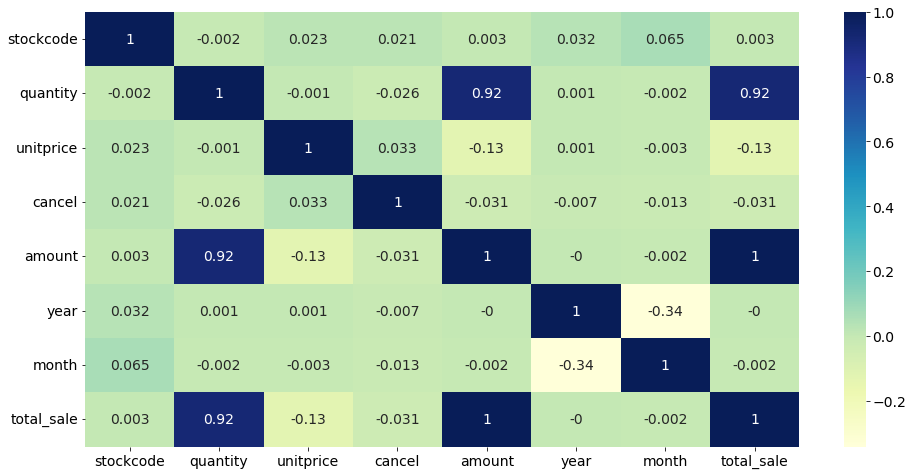

In [11]:
# without changing df
dataplot = sns.heatmap(df.corr().round(3), cmap="YlGnBu", annot=True)
  
# displaying heatmap
plt.show()

In [12]:
df[df['invoiceno']=='536365'] 

,invoiceno,stockcode,product,quantity,unitprice,customerid,country,cancel,amount,year,month,total_sale,year_month
0,536365,3249,3498,6,2.55,17850,United Kingdom,False,15.30,2010,12,15.30,2010-12
1,536365,2649,3506,6,3.39,17850,United Kingdom,False,20.34,2010,12,20.34,2010-12
2,536365,2855,819,8,2.75,17850,United Kingdom,False,22.00,2010,12,22.00,2010-12
3,536365,2803,1695,6,3.39,17850,United Kingdom,False,20.34,2010,12,20.34,2010-12
4,536365,2802,2614,6,3.39,17850,United Kingdom,False,20.34,2010,12,20.34,2010-12
5,536365,1605,2803,2,7.65,17850,United Kingdom,False,15.30,2010,12,15.30,2010-12
6,536365,755,1351,6,4.25,17850,United Kingdom,False,25.50,2010,12,25.50,2010-12


Some order has been cancelled. So we do our analysis for completed orders.

In [13]:
completed_orders = df[df['cancel']==False]
completed_orders

,invoiceno,stockcode,product,quantity,unitprice,customerid,country,cancel,amount,year,month,total_sale,year_month
0,536365,3249,3498,6,2.55,17850,United Kingdom,False,15.30,2010,12,15.30,2010-12
1,536365,2649,3506,6,3.39,17850,United Kingdom,False,20.34,2010,12,20.34,2010-12
2,536365,2855,819,8,2.75,17850,United Kingdom,False,22.00,2010,12,22.00,2010-12
3,536365,2803,1695,6,3.39,17850,United Kingdom,False,20.34,2010,12,20.34,2010-12
4,536365,2802,2614,6,3.39,17850,United Kingdom,False,20.34,2010,12,20.34,2010-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
401559,581587,1470,2120,12,0.85,12680,France,False,10.20,2011,12,10.20,2011-12
401560,581587,1746,664,6,2.10,12680,France,False,12.60,2011,12,12.60,2011-12
401561,581587,2086,670,4,4.15,12680,France,False,16.60,2011,12,16.60,2011-12
401562,581587,2087,669,4,4.15,12680,France,False,16.60,2011,12,16.60,2011-12


Below, it has been demonstrated that the product's price is varied time to time

In [14]:
product0 = completed_orders[completed_orders['product']==0].sort_values(by=['year_month'])
product0

,invoiceno,stockcode,product,quantity,unitprice,customerid,country,cancel,amount,year,month,total_sale,year_month
1033,536522,2692,0,2,2.55,15012,United Kingdom,False,5.10,2010,12,5.10,2010-12
5131,537044,2692,0,12,2.55,18055,United Kingdom,False,30.60,2010,12,30.60,2010-12
28072,540247,2692,0,1,2.55,15464,United Kingdom,False,2.55,2011,1,2.55,2011-01
43711,542226,2692,0,1,2.55,17075,United Kingdom,False,2.55,2011,1,2.55,2011-01
67923,545186,2692,0,1,2.55,17841,United Kingdom,False,2.55,2011,2,2.55,2011-02
96341,548642,2692,0,3,2.55,17287,United Kingdom,False,7.65,2011,4,7.65,2011-04
98213,548808,2692,0,3,2.55,17774,United Kingdom,False,7.65,2011,4,7.65,2011-04
110958,550459,2692,0,1,2.55,18116,United Kingdom,False,2.55,2011,4,2.55,2011-04
142848,554506,2692,0,2,2.55,14083,United Kingdom,False,5.10,2011,5,5.10,2011-05
132562,553194,2692,0,1,2.55,16283,United Kingdom,False,2.55,2011,5,2.55,2011-05


Let's assume, product A's unit price is \\$2 and sold for 10 times. Total sales = 10x2 = \\$20. Another product B's unit price is \\$10 and sold for 2 times. Total sales = 2x10 = \\$20. 

So, we assume here, product A is more profitable than product B because product A has sold most.

In [15]:
# which products are sold most in numbers of sales (means how much money the product gains)
# and in number of per invoice (means the number of customer choose the product in his order) 
# and in number of quantity (means how maany this product has been sold)
# within 2010-2011?

# ordered by total_quantity, as we assume the most profitable product is sold the most times
product_quantity = duckdb.query("""
select product, sum(total_sale) as total_sale, count(invoiceno) as total_invoice, sum(quantity) as total_quantity 
from completed_orders group by product order by total_quantity DESC
""").df()
product_quantity

,product,total_sale,total_invoice,total_quantity
0,2183,168469.60,1,80995.0
1,1871,81416.73,198,77916.0
2,3584,13558.41,472,54319.0
3,2451,37206.88,1060,49160.0
4,1661,85040.54,1615,46078.0
...,...,...,...,...
3642,265,3.75,1,1.0
3643,488,5.95,1,1.0
3644,336,2.95,1,1.0
3645,2093,1.25,1,1.0


We observed the most profitable products in terms to quantity. But the product which was sold in the highest quantity was ordered only for one time. So this isn't a good measure to identify the most profitable products. Further if we consider sales amount to identify the most profitable products then we may end up with products with much more unit price but were sold in less quantity. So here we considered the most profitable products in terms of Order.

In [16]:
product_quantity = product_quantity.sort_values(by=['total_invoice', 'total_quantity'])
product_quantity

,product,total_sale,total_invoice,total_quantity
3595,1895,2.95,1,1.0
3596,835,1.65,1,1.0
3597,487,5.95,1,1.0
3598,1281,1.25,1,1.0
3599,432,4.65,1,1.0
...,...,...,...,...
26,2204,68785.23,1389,15279.0
6,205,56413.03,1395,35263.0
4,1661,85040.54,1615,46078.0
43,2618,142264.75,1713,12374.0


In [17]:
top_5_products_in_2010_2011 = list(product_quantity['product'].head(5))
print("Top 5 sold products (in terms of order):", top_5_products_in_2010_2011, 
      [product_classes[i] for i in top_5_products_in_2010_2011])

Top 5 sold products (in terms of order): [1895, 835, 487, 1281, 432] ['MIDNIGHT BLUE CRYSTAL DROP EARRINGS', 'CROCHET LILAC/RED BEAR KEYRING', 'BLUE/GREEN SHELL NECKLACE W PENDANT', 'FUNKY MONKEY MUG', 'BLUE NEW BAROQUE FLOCK CANDLESTICK']


The product's profit (as we assume the most profittable product is sold most \[total_quantity\]) is correlated to the customer's choice to buy it \[total_invoice\]. And, if a customer choose a product most, it's total sale will increase (correlation of total_sale and total_invoice = 0.82).

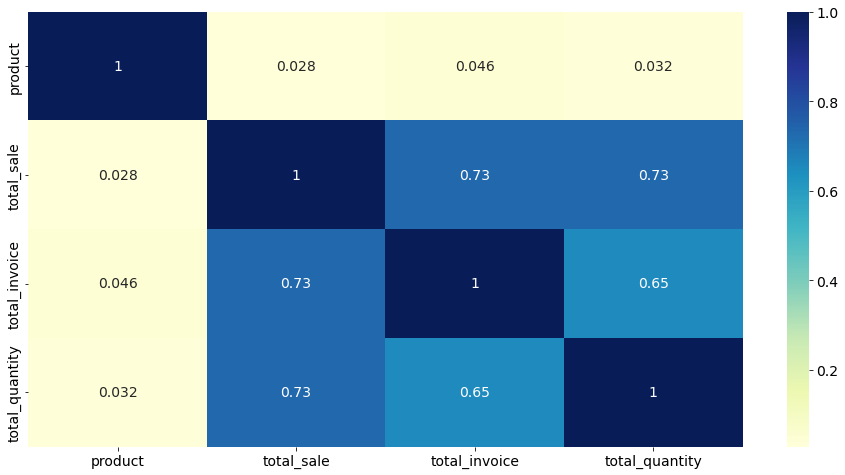

In [18]:
dataplot = sns.heatmap(product_quantity.corr().round(3), cmap="YlGnBu", annot=True)

In [19]:
# get the product information of total sales and their unit price varies within year_month

product_infos = duckdb.query("""
select q1.*, q2.unitprice from 
(select distinct unitprice, year_month as date, product as product_id from completed_orders) as q2 inner join
(select year_month, product, sum(total_sale) as total_sale, count(invoiceno) as total_invoice, 
sum(quantity) as total_quantity from completed_orders group by year_month, product) as q1 
on 
q1.year_month=q2.date and q1.product=q2.product_id
order by product, year_month ASC
""").df()

product_infos.head(30)

,year_month,product,total_sale,total_invoice,total_quantity,unitprice
0,2010-12,0,35.70,2,14.0,2.55
1,2011-01,0,5.10,2,2.0,2.55
2,2011-02,0,2.55,1,1.0,2.55
3,2011-04,0,17.85,3,7.0,2.55
4,2011-05,0,7.65,2,3.0,2.55
5,2011-06,0,5.10,1,2.0,2.55
6,2011-07,0,7.65,2,3.0,2.55
7,2011-08,0,2.55,1,1.0,2.55
8,2011-09,0,22.95,3,9.0,2.55
9,2011-10,0,7.65,3,3.0,2.55


Top 5 sold products (in terms of order): [1895, 835, 487, 1281, 432]


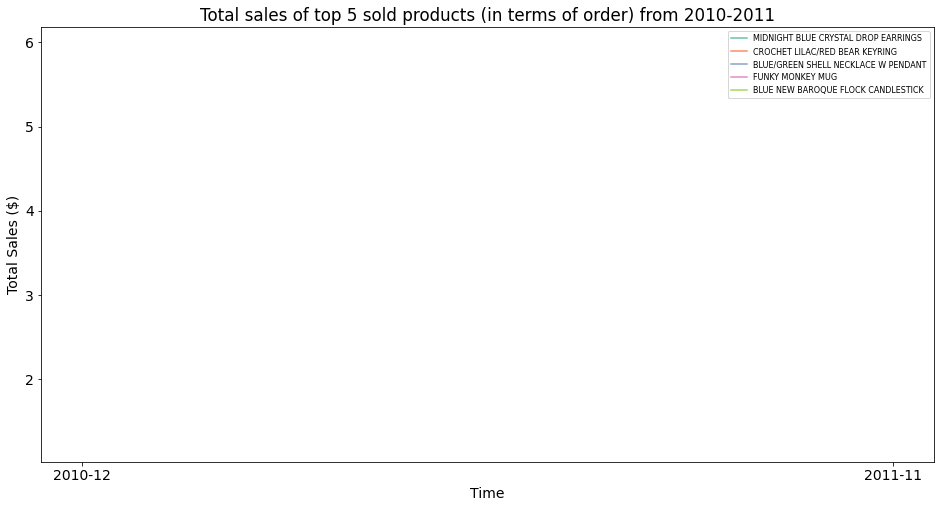

In [20]:
print('Top 5 sold products (in terms of order):', top_5_products_in_2010_2011)

product_infos_top_5 = product_infos[product_infos['product'].isin(top_5_products_in_2010_2011)]

sns.lineplot(x="year_month", y="total_sale",
             hue="product",
             palette="Set2",
             data=product_infos_top_5)

plt.xlabel("Time")
plt.ylabel("Total Sales ($)")
plt.title("Total sales of top 5 sold products (in terms of order) from 2010-2011")
plt.legend([product_classes[i] for i in top_5_products_in_2010_2011], 
           loc='upper right', 
           prop={'size': 8})

It has been seen that from August 2011, the unit price has been varied.

In [21]:
print(product_infos['unitprice'].max(), 
      product_infos['unitprice'].min(), product_infos['unitprice'].median())

8142.75 0.001 1.95


As the median unit price is \\$1.95 and the unit prices of top 5 sold products (in terms of order) are below than \\$2, so we plot the box plot for those products whose unit price have less than \\$2

Text(0, 0.5, 'Unit Price ($)')

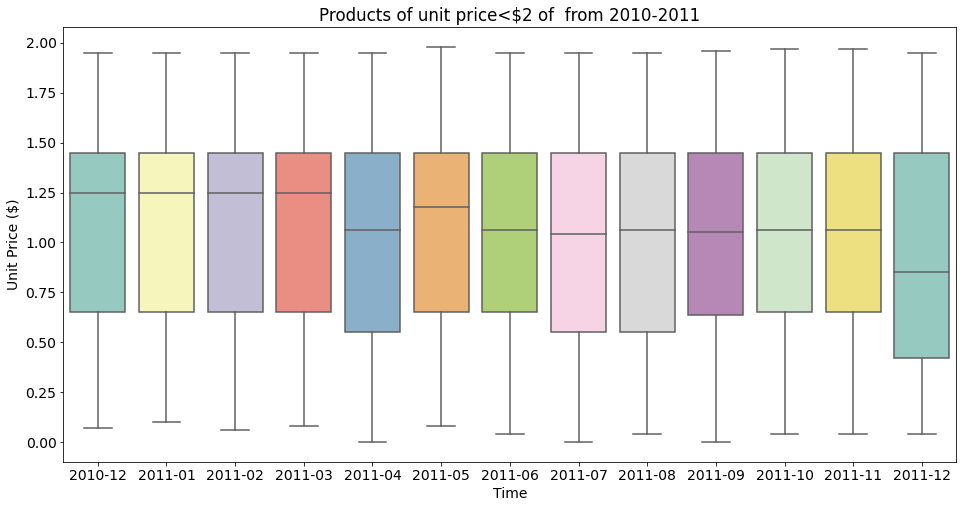

In [22]:
plt.title("Products of unit price<$2 of  from 2010-2011")
sns.boxplot(x="year_month", y="unitprice", 
            data=product_infos[product_infos['unitprice']<2].sort_values(['year_month'], ascending=[True]), 
            palette="Set3")
plt.xlabel("Time")
plt.ylabel("Unit Price ($)")

Top 5 sold products (in terms of order): [1895, 835, 487, 1281, 432]


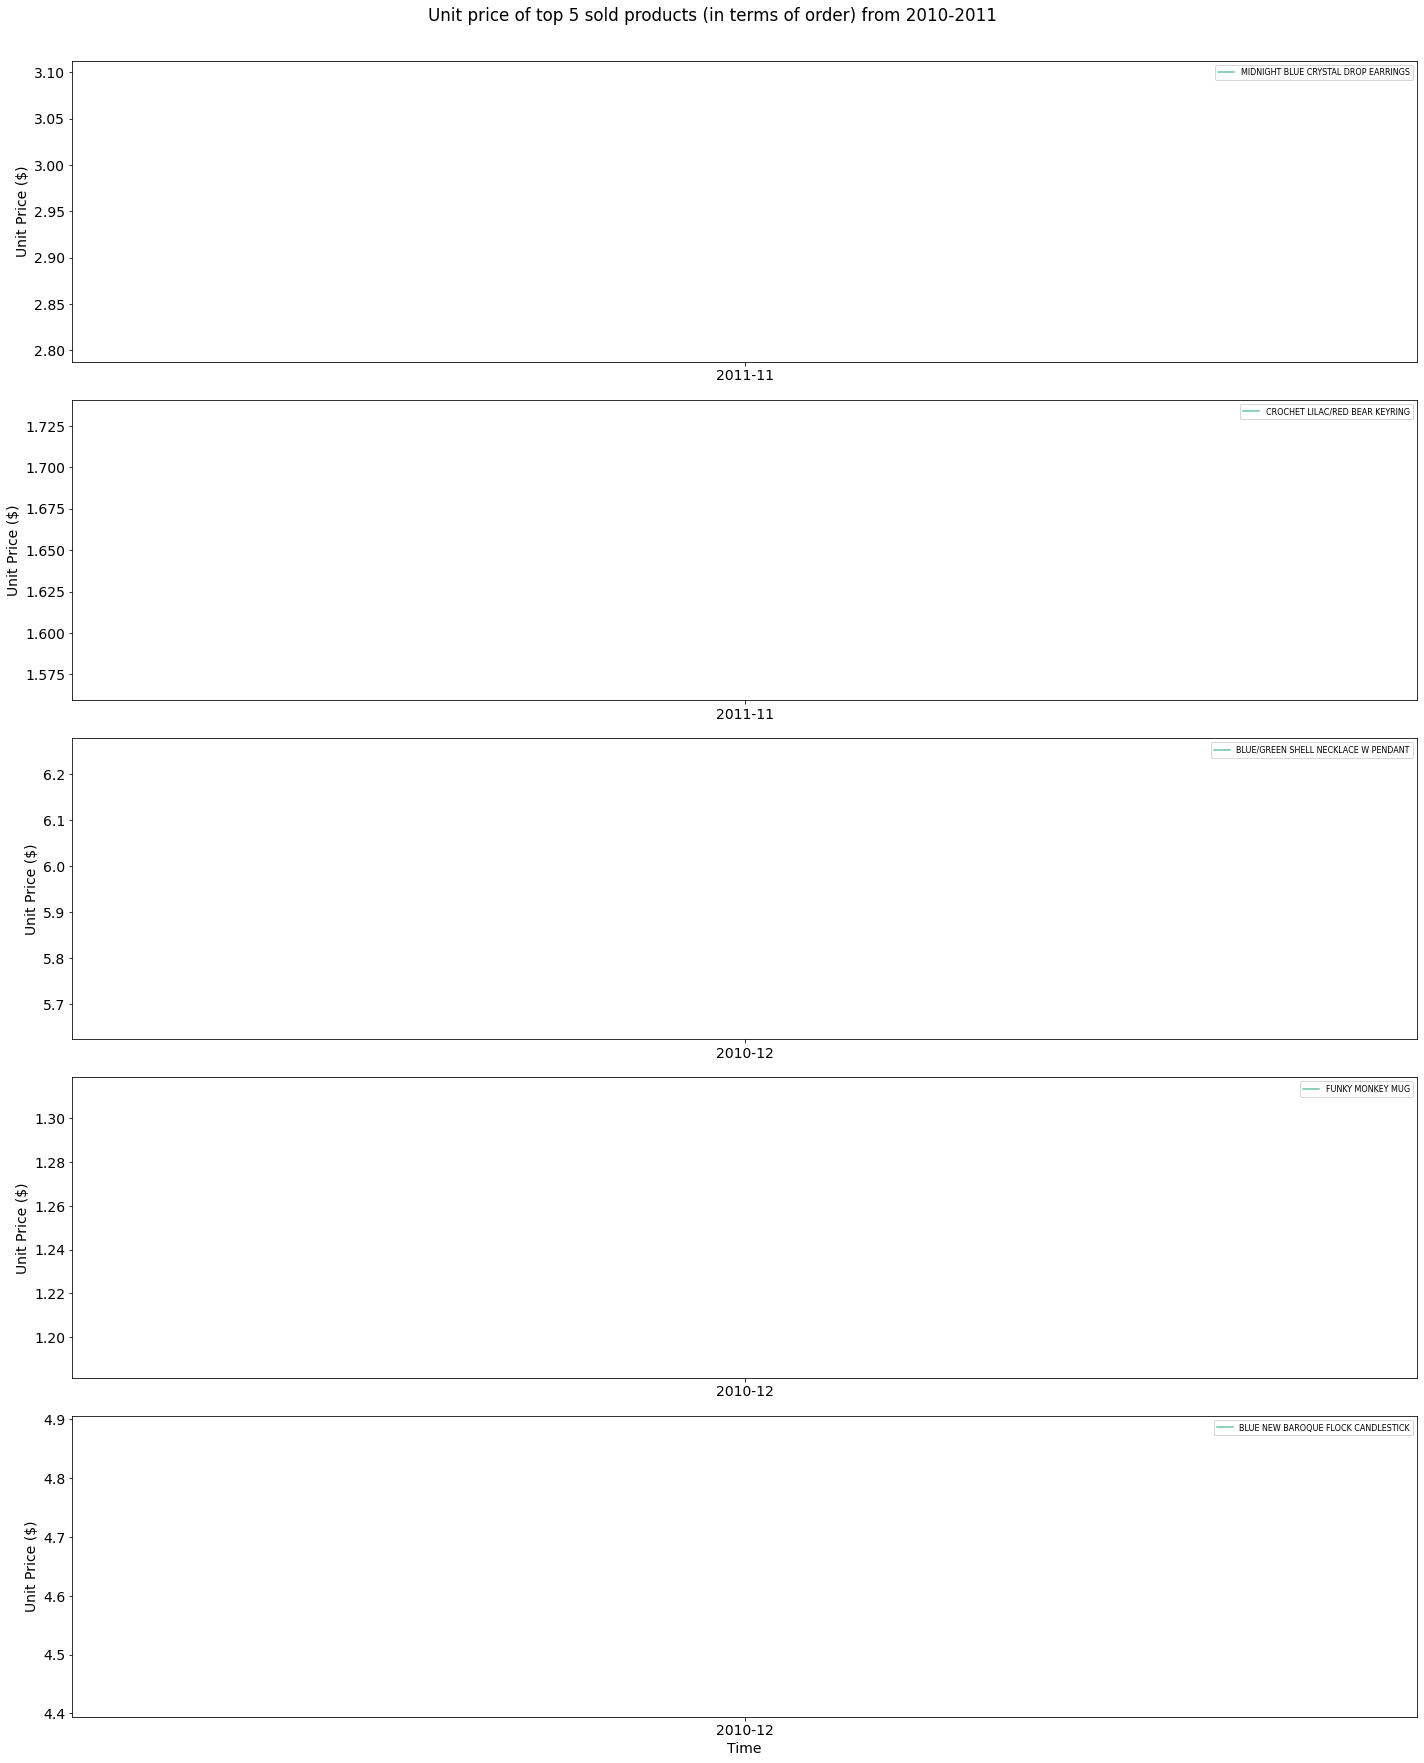

In [23]:
print('Top 5 sold products (in terms of order):', top_5_products_in_2010_2011)

fig, ax =plt.subplots(5,1, figsize=(20,25))

fig.suptitle("Unit price of top 5 sold products (in terms of order) from 2010-2011")
for i in range(5):
    product_infos_top_5 = product_infos[product_infos['product'].isin([top_5_products_in_2010_2011[i]])]
    sns.lineplot(x="year_month", y="unitprice",
                 hue="product",
                 palette="Set2",
                 data=product_infos_top_5, ax=ax[i])
    
    ax[i].set_ylabel("Unit Price ($)")
    if i+1 == 5:
        ax[i].set_xlabel("Time")
    else:
        ax[i].set_xlabel("")
    
    ax[i].legend([product_classes[top_5_products_in_2010_2011[i]]], 
               loc='upper right', 
               prop={'size': 8})

fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

In [24]:
print(le_country.classes_, len(le_country.classes_)) # get the class names of coutries

country_classes = le_country.classes_
country_classes = {i: country_classes[i] for i in range(len(le_country.classes_))}

['Australia' 'Austria' 'Bahrain' 'Belgium' 'Brazil' 'Canada'
 'Channel Islands' 'Cyprus' 'Czech Republic' 'Denmark' 'EIRE'
 'European Community' 'Finland' 'France' 'Germany' 'Greece' 'Iceland'
 'Israel' 'Italy' 'Japan' 'Lebanon' 'Lithuania' 'Malta' 'Netherlands'
 'Norway' 'Poland' 'Portugal' 'RSA' 'Saudi Arabia' 'Singapore' 'Spain'
 'Sweden' 'Switzerland' 'USA' 'United Arab Emirates' 'United Kingdom'
 'Unspecified'] 37


In [25]:
# get the sales information for regions

product_region_infos = duckdb.query("""
select country, sum(total_sale) as total_sale, count(invoiceno) as total_invoice, sum(quantity) as total_quantity 
from completed_orders group by country order by total_quantity DESC
""").df()

product_region_infos.head(30)

,country,total_sale,total_invoice,total_quantity
0,United Kingdom,7285024.644,349203,4241305.0
1,Netherlands,285446.340,2359,200361.0
2,EIRE,265262.460,7226,140133.0
3,Germany,228678.400,9025,119154.0
4,France,208934.310,8326,111428.0
5,Australia,138453.810,1181,83891.0
6,Sweden,38367.830,450,36078.0
7,Switzerland,56443.950,1841,30082.0
8,Spain,61558.560,2479,27933.0
9,Japan,37416.370,321,26016.0


In [26]:
product_region_infos = duckdb.query("""
select country, sum(total_sale) as total_sale, count(invoiceno) as total_invoice, sum(quantity) as total_quantity 
from completed_orders group by country order by total_quantity DESC
""").df()

product_region_infos.head(30)

,country,total_sale,total_invoice,total_quantity
0,United Kingdom,7285024.644,349203,4241305.0
1,Netherlands,285446.340,2359,200361.0
2,EIRE,265262.460,7226,140133.0
3,Germany,228678.400,9025,119154.0
4,France,208934.310,8326,111428.0
5,Australia,138453.810,1181,83891.0
6,Sweden,38367.830,450,36078.0
7,Switzerland,56443.950,1841,30082.0
8,Spain,61558.560,2479,27933.0
9,Japan,37416.370,321,26016.0


It seems that, though United Kingdom has most ptofit in term of sales, but the mean sales has been placed in Nehterland.

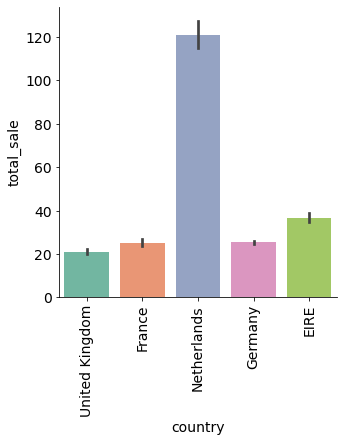

In [27]:
product_region_infos_top_5 = df[df['country'].isin(list(product_region_infos['country'].head(5)))]
product_region_infos_top_5 = product_region_infos_top_5[product_region_infos_top_5['total_sale']>0]

sns.catplot(x="country", y="total_sale", 
            data=product_region_infos_top_5, 
            palette="Set2", kind='bar')

plt.xticks(rotation=90)
plt.show()

In [28]:
# estimate the model and save it as lm (linear model)
lm = ols("quantity ~ month + year", data=df).fit()

In [29]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:               quantity   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.247
Date:                Wed, 29 Jun 2022   Prob (F-statistic):              0.287
Time:                        14:04:57   Log-Likelihood:            -2.7862e+06
No. Observations:              401564   AIC:                         5.572e+06
Df Residuals:                  401561   BIC:                         5.572e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -349.4640   3402.578     -0.103      0.9

In [ ]:
fig = sm.graphics.influence_plot(lm, criterion="cooks")
fig.tight_layout(pad=1.0)